<a href="https://colab.research.google.com/github/hamidds/Stocks-Price-Predictor/blob/main/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading Libraries which we need

In [ ]:
import pandas as pd
import urllib.request, json
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from datetime import datetime
import pandas_datareader.data as web
api_key = '7C0LD1DCRKEJQV8H'
stock_sym = "AAL"
data_src = "av-daily"
df = web.DataReader(stock_sym, data_src, start=datetime(2000, 2, 9),
                    end=datetime(2020, 5, 24),
                    api_key=api_key)
df.to_csv(stock_sym + '_' +  data_src + ".csv")
df = pd.read_csv(stock_sym + '_' + data_src + ".csv")


In [ ]:
df = df.rename(columns={'Unnamed: 0': 'Date'})
# df.columns
df.head()
df.dropna()
df

,Date,open,high,low,close,volume
0,2005-09-27,21.05,21.40,19.10,19.30,2576944
1,2005-09-28,19.30,20.53,19.20,20.50,15409920
2,2005-09-29,20.40,20.58,20.10,20.21,2890617
3,2005-09-30,20.26,21.05,20.18,21.01,8373458
4,2005-10-03,20.90,21.75,20.90,21.50,2836193
...,...,...,...,...,...,...
3684,2020-05-18,9.62,9.94,9.36,9.87,76624405
3685,2020-05-19,10.14,10.19,9.59,9.64,62242475
3686,2020-05-20,9.91,10.14,9.77,9.87,44006731
3687,2020-05-21,9.87,10.15,9.83,9.89,45785718


In [ ]:
h = df['high']
l = df['low']
c = df['close']
hlc3 = (h+l+c)/3 
df_hlc3 = pd.DataFrame({'hlc3':hlc3})
# df_hlc3

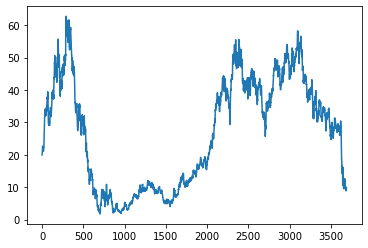

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df_hlc3)

**Normalizing our data using MinMaxScaler**

*   LSTMs are sensetive to the scale of the data.



In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df_hlc3 = scaler.fit_transform(np.array(df_hlc3).reshape(-1,1))
df_hlc3

array([[0.29817466],
       [0.30052465],
       [0.3041316 ],
       ...,
       [0.13411302],
       [0.13460487],
       [0.13230954]])

In [ ]:
training_size = int(len(df_hlc3) * 0.7)
test_size = len(df_hlc3) - training_size
train_set, test_set = df_hlc3[0:training_size, :] , df_hlc3[training_size:len(df_hlc3), : 1]

In [ ]:
def create_dataset(dataset, time_step=1):
	X, Y = [], []
	for i in range(len(dataset) - time_step - 1):
		a = dataset[i:(i+time_step), 0] 
		X.append(a)
		Y.append(dataset[i + time_step, 0])
	return np.array(X), np.array(Y)

Create matrices for training set and test set


In [ ]:
time_step = 200
x_train, y_train = create_dataset(train_set, time_step)
x_test, y_test = create_dataset(test_set, time_step)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test  = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape = (time_step, 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
38/38 [==============================] - 16s 327ms/step - loss: 0.0483 - val_loss: 0.0040
Epoch 2/100
38/38 [==============================] - 12s 313ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 3/100
38/38 [==============================] - 12s 318ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 4/100
38/38 [==============================] - 12s 322ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 5/100
38/38 [==============================] - 12s 318ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 6/100
38/38 [==============================] - 12s 319ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 7/100
38/38 [==============================] - 12s 316ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 8/100
38/38 [==============================] - 12s 319ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 9/100
38/38 [==============================] - 12s 323ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 10/100
38/38 [==============================] - 12s 326ms/step - loss: 9.474

**Model Evaluation**

1.   Calculating Root Mean Square Error (RMSE)








In [ ]:
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error

train_predict=model.predict(x_train)
test_predict=model.predict(x_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

26.90309004184145
39.805422565415185


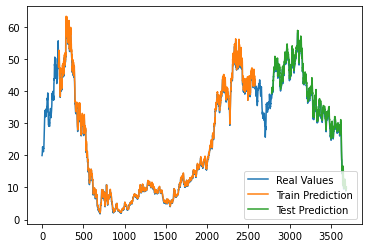

In [ ]:
### Plotting 
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_hlc3)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict) + time_step, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_hlc3)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (time_step*2) + 1:len(df_hlc3) - 1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_hlc3), label='Real Values')
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.legend()
# plt.show()